# Node Transfer Time-Series Analysis

This notebook visualizes the load distribution across nodes over time during BenchFS benchmark runs.

## Data Source
- `node_transfer_aggregated.csv`: Aggregated transfer data per second, per client, per target node

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [2]:
# Load the aggregated CSV
# Update this path to your results directory
RESULTS_DIR = Path('/work/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2026.01.23-01.26.56-debug_large/2026.01.23-01.29.11-537344.nqsv-16')

csv_path = RESULTS_DIR / 'node_transfer_aggregated.csv'
if not csv_path.exists():
    print(f"CSV not found at {csv_path}")
    print("Please update RESULTS_DIR to point to your job results directory")
else:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded 101268 records
Columns: ['time_bucket', 'client_node', 'op', 'target_node', 'total_bytes', 'transfer_count']


In [3]:
# Convert time_bucket to relative time (seconds from start)
df['time_relative'] = df['time_bucket'] - df['time_bucket'].min()

# Convert bytes to GiB
df['total_gib'] = df['total_bytes'] / (1024**3)

# Basic statistics
print(f"Time range: {df['time_bucket'].min()} - {df['time_bucket'].max()} (duration: {df['time_relative'].max()}s)")
print(f"Operations: {df['op'].unique()}")
print(f"Target nodes: {sorted(df['target_node'].unique())}")
print(f"Client nodes: {sorted(df['client_node'].unique())}")

Time range: 59506 - 59926 (duration: 420s)
Operations: ['WRITE' 'READ']
Target nodes: ['node_0', 'node_1', 'node_10', 'node_11', 'node_12', 'node_13', 'node_14', 'node_15', 'node_2', 'node_3', 'node_4', 'node_5', 'node_6', 'node_7', 'node_8', 'node_9']
Client nodes: ['bnode005', 'bnode049', 'bnode051', 'bnode052', 'bnode054', 'bnode055', 'bnode056', 'bnode057', 'bnode085', 'bnode086', 'bnode088', 'bnode090', 'bnode095', 'bnode096', 'bnode099', 'bnode123']


## 1. Overall Throughput Over Time

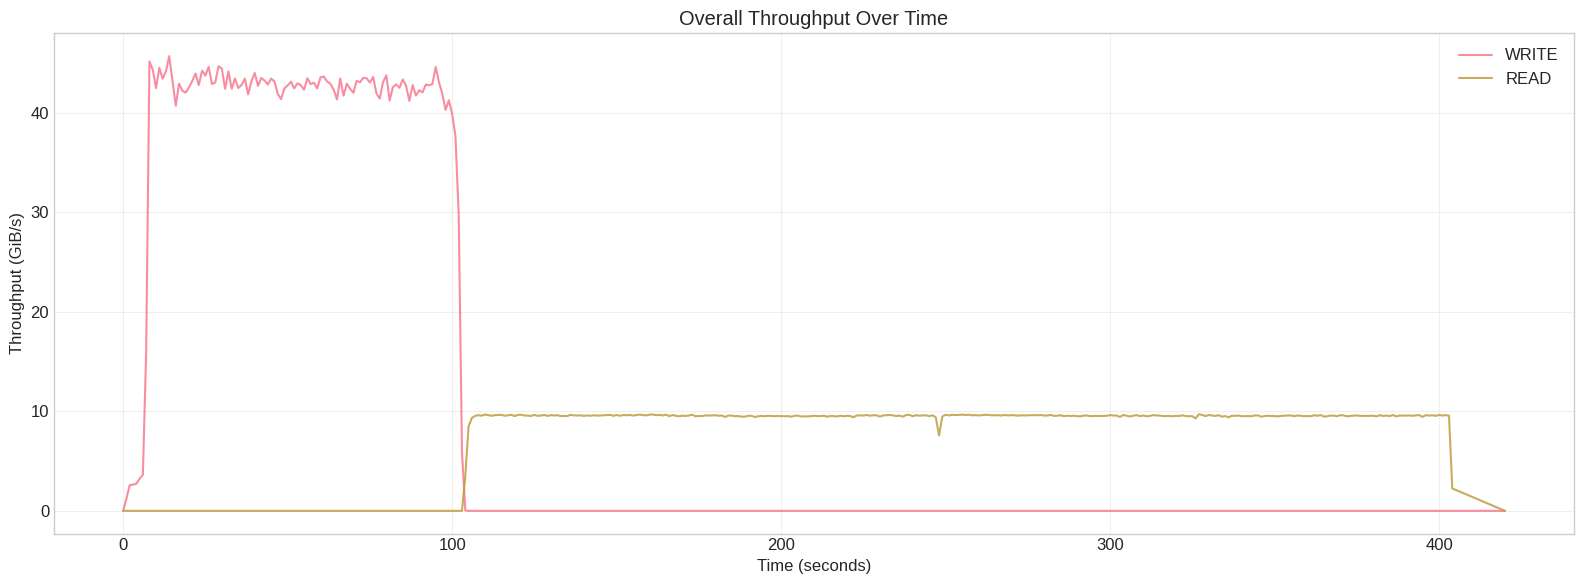

In [4]:
# Aggregate throughput by time and operation
throughput_by_time = df.groupby(['time_relative', 'op'])['total_gib'].sum().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))

if 'WRITE' in throughput_by_time.columns:
    ax.plot(throughput_by_time.index, throughput_by_time['WRITE'], label='WRITE', linewidth=1.5, alpha=0.8)
if 'READ' in throughput_by_time.columns:
    ax.plot(throughput_by_time.index, throughput_by_time['READ'], label='READ', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Throughput (GiB/s)')
ax.set_title('Overall Throughput Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'throughput_over_time.png', dpi=150)
plt.show()

## 2. Per-Target-Node Throughput Over Time

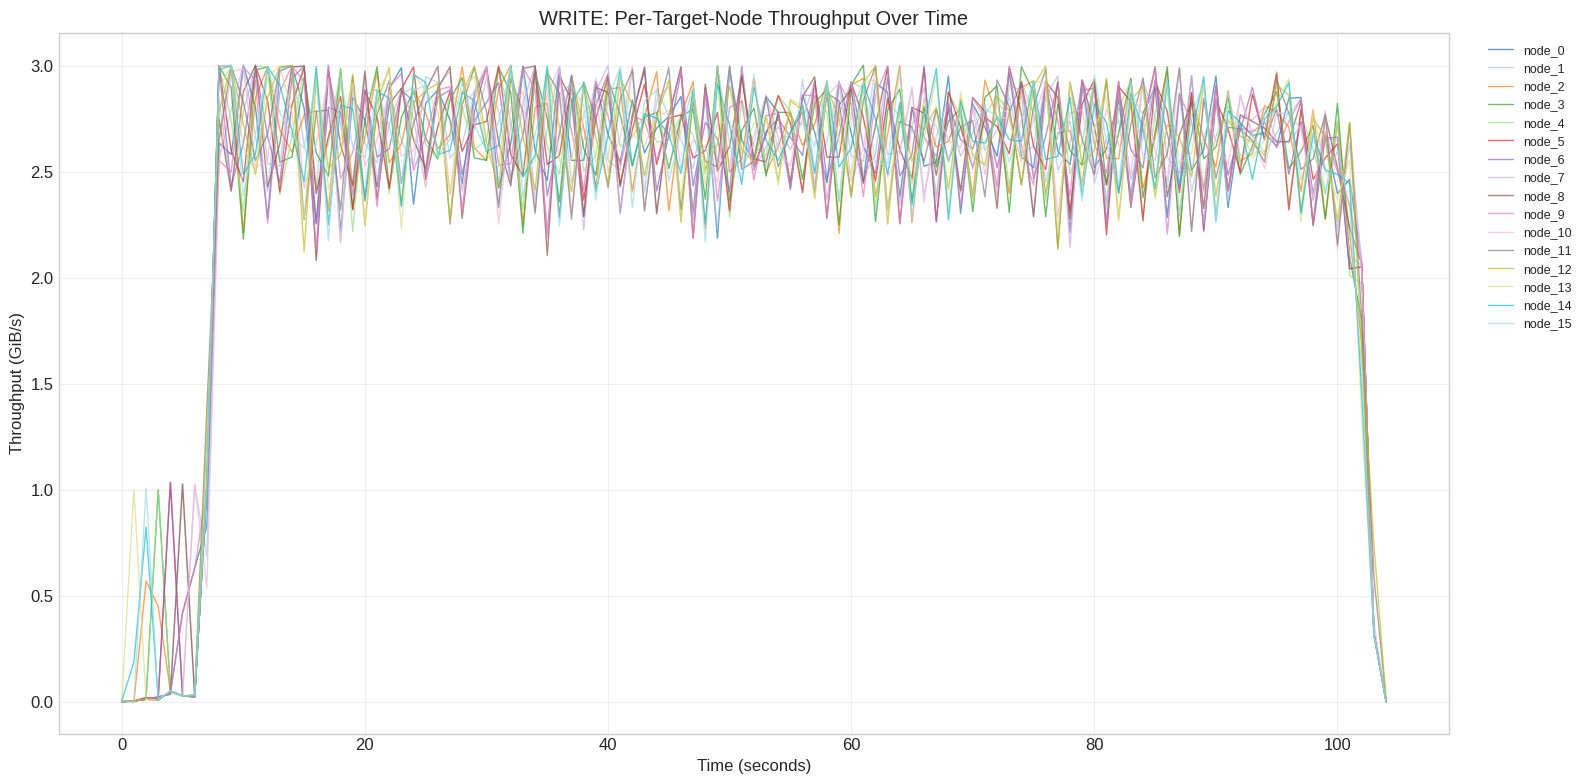

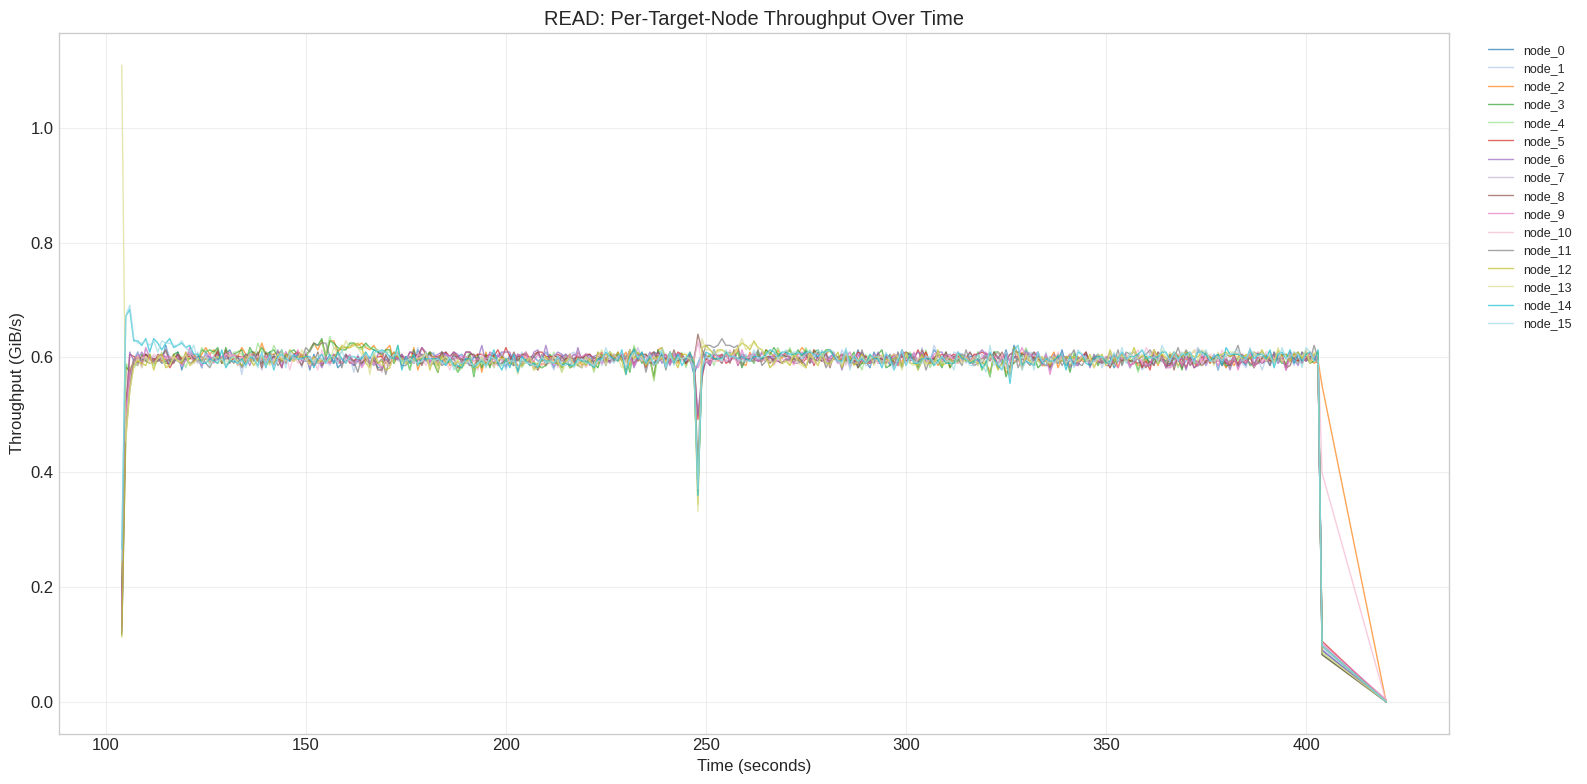

In [5]:
# Separate WRITE and READ phases
df_write = df[df['op'] == 'WRITE']
df_read = df[df['op'] == 'READ']

def plot_per_node_throughput(data, title, filename):
    """Plot throughput per target node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally (node_0, node_1, ..., node_15)
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    for i, col in enumerate(node_throughput.columns):
        ax.plot(node_throughput.index, node_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_per_node_throughput(df_write, 'WRITE: Per-Target-Node Throughput Over Time', 'write_per_node_throughput.png')
plot_per_node_throughput(df_read, 'READ: Per-Target-Node Throughput Over Time', 'read_per_node_throughput.png')

## 3. Stacked Area Chart - Load Distribution

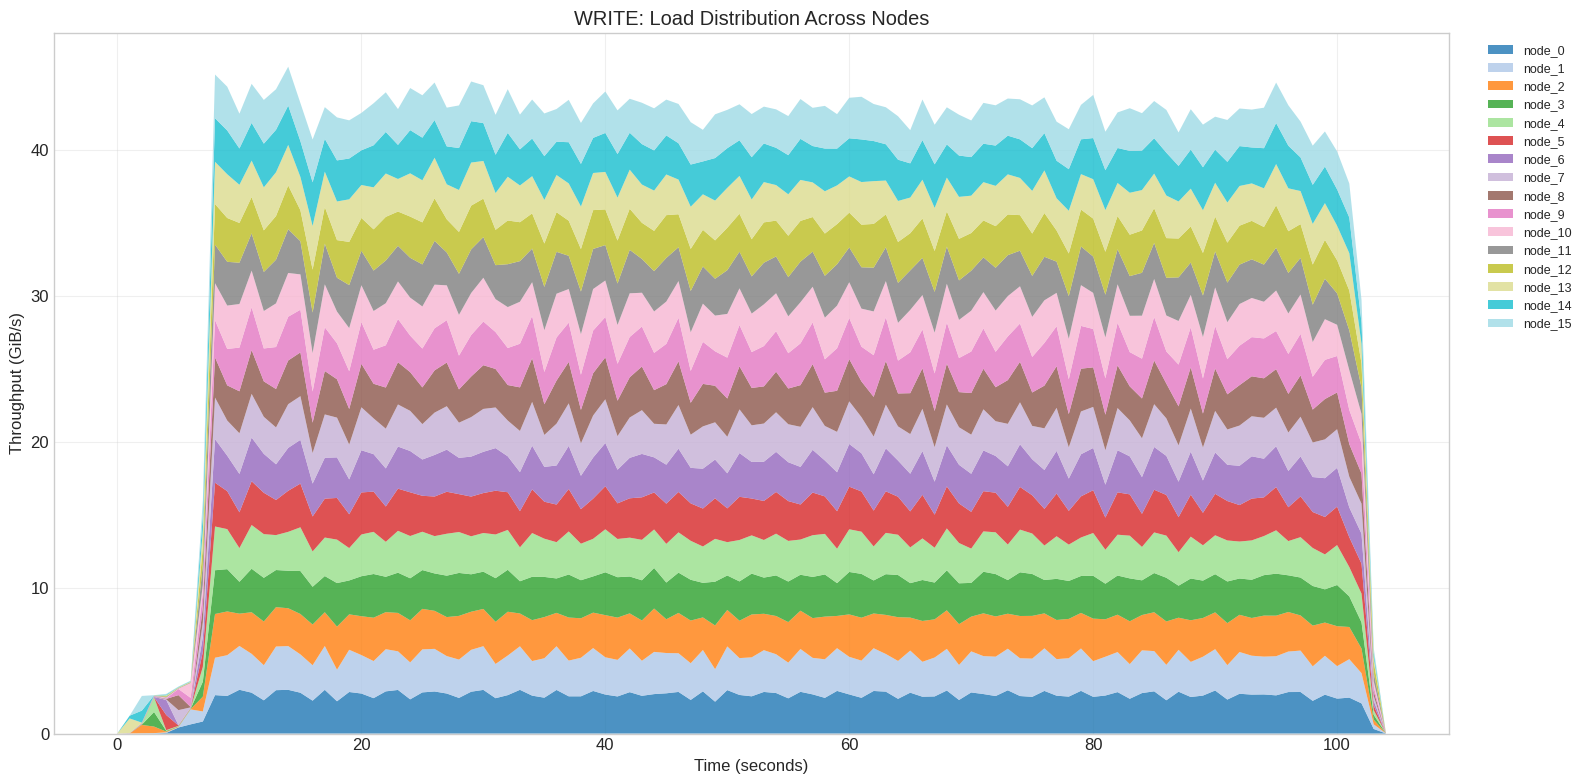

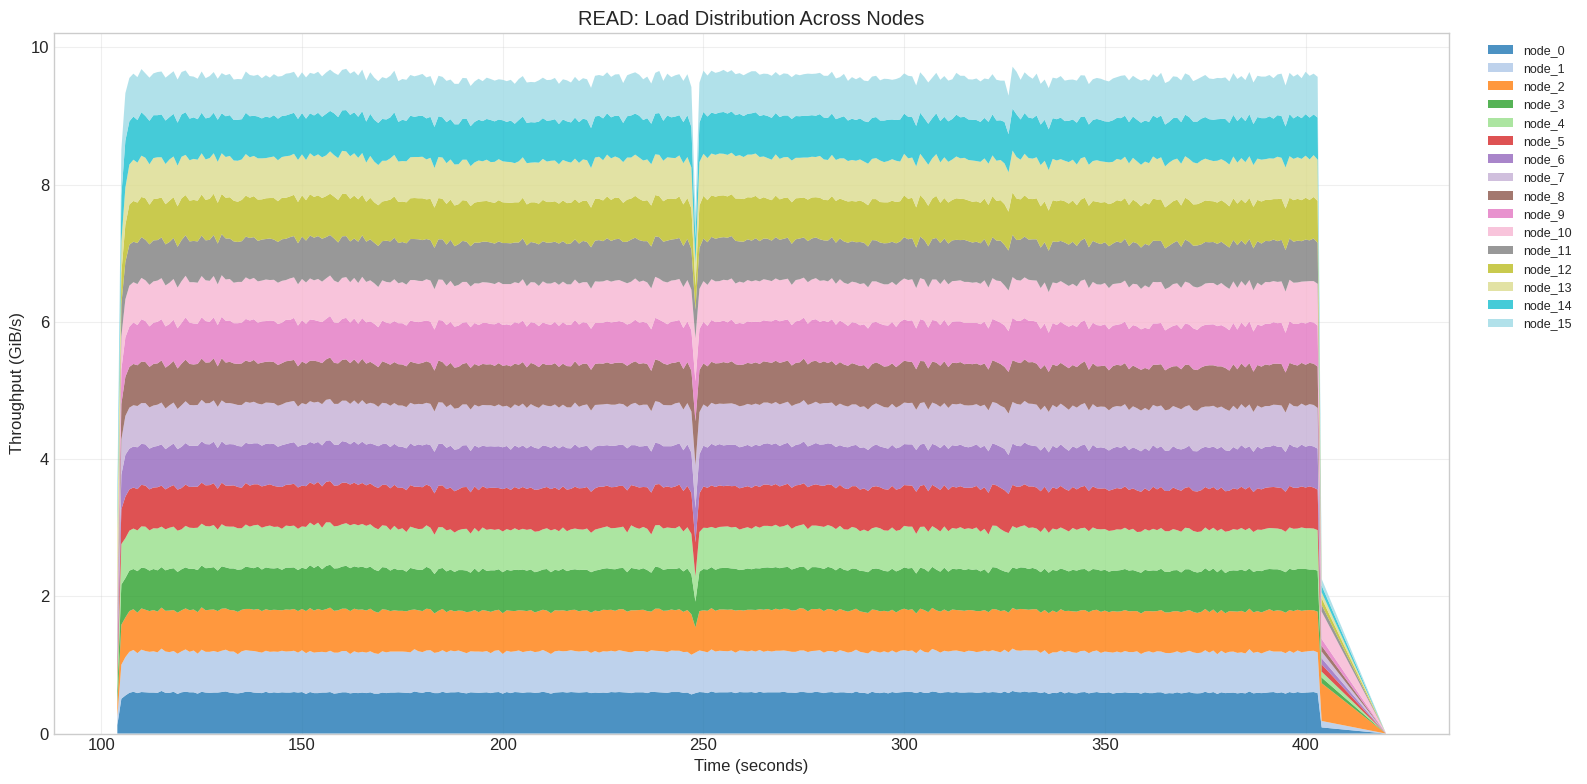

In [6]:
def plot_stacked_area(data, title, filename):
    """Plot stacked area chart showing load distribution"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(node_throughput.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    node_throughput = node_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(node_throughput.columns)))
    
    ax.stackplot(node_throughput.index, 
                 [node_throughput[col] for col in node_throughput.columns],
                 labels=node_throughput.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_stacked_area(df_write, 'WRITE: Load Distribution Across Nodes', 'write_load_distribution.png')
plot_stacked_area(df_read, 'READ: Load Distribution Across Nodes', 'read_load_distribution.png')

## 4. Per-Client-Node Throughput

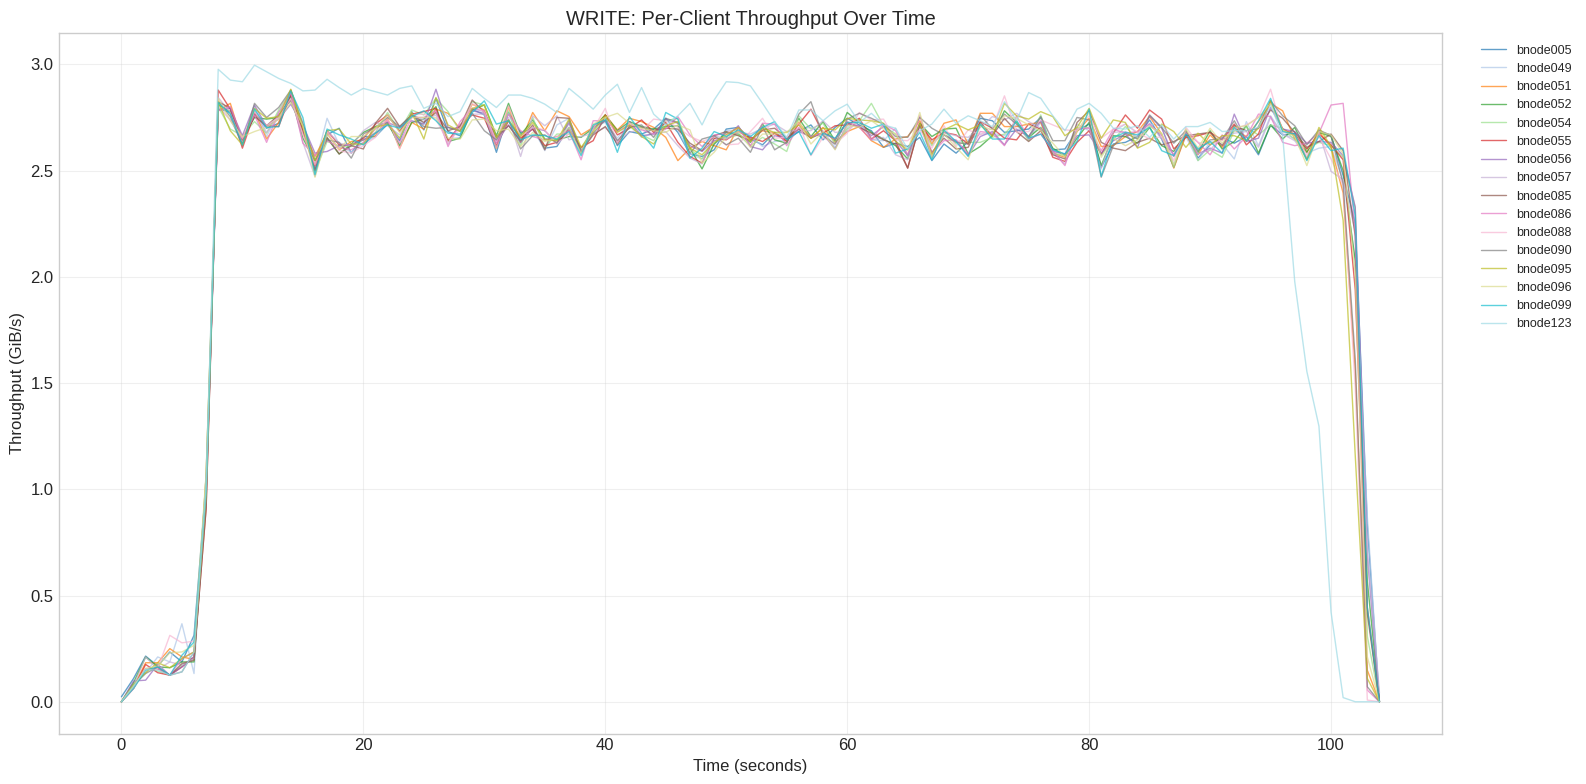

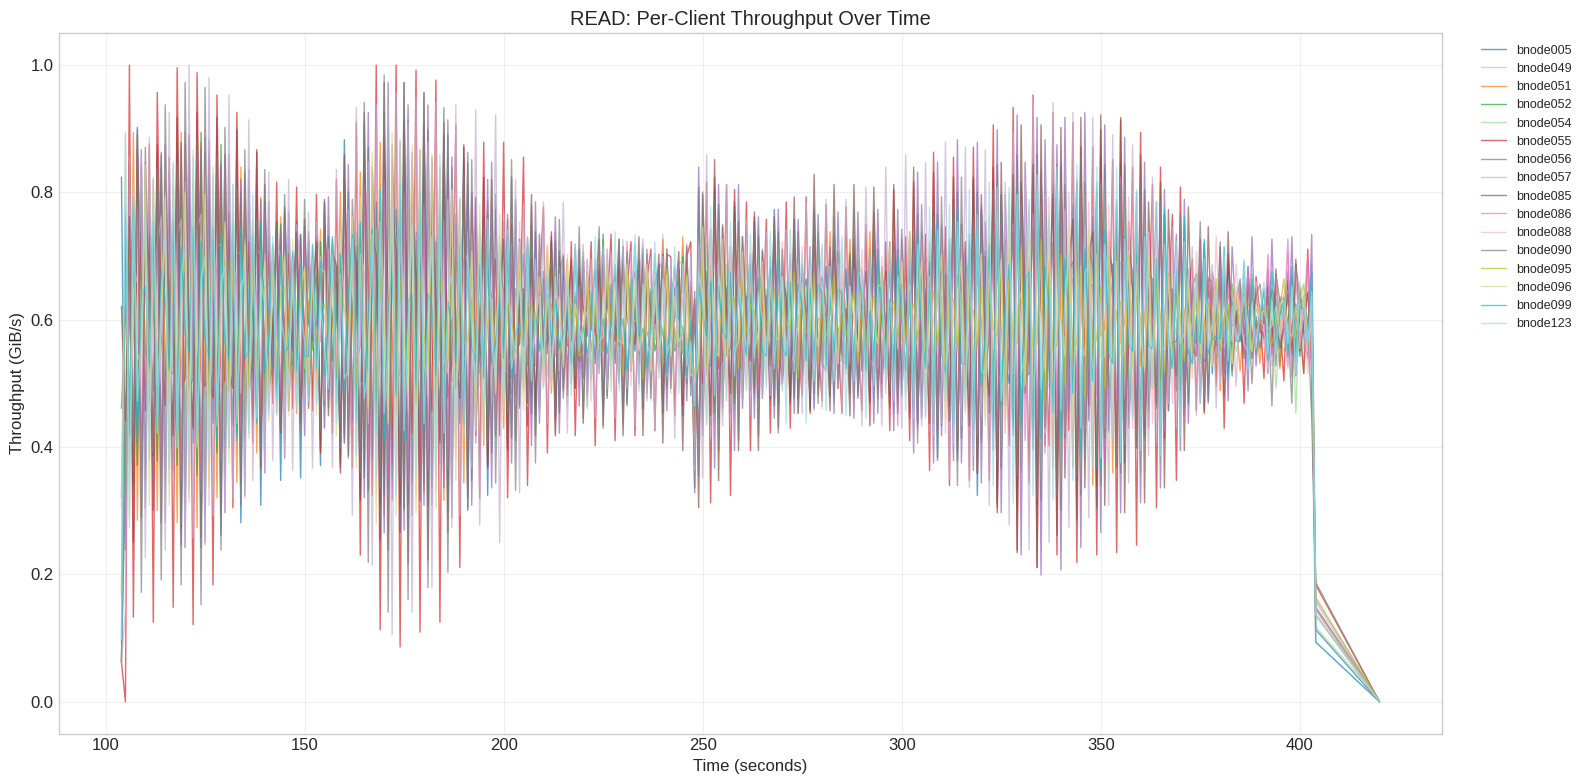

In [7]:
def plot_per_client_throughput(data, title, filename):
    """Plot throughput per client node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and client node
    client_throughput = data.groupby(['time_relative', 'client_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns
    sorted_cols = sorted(client_throughput.columns)
    client_throughput = client_throughput[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(client_throughput.columns)))
    
    for i, col in enumerate(client_throughput.columns):
        ax.plot(client_throughput.index, client_throughput[col], 
                label=col, linewidth=1, alpha=0.7, color=colors[i])
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Throughput (GiB/s)')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_per_client_throughput(df_write, 'WRITE: Per-Client Throughput Over Time', 'write_per_client_throughput.png')
plot_per_client_throughput(df_read, 'READ: Per-Client Throughput Over Time', 'read_per_client_throughput.png')

## 5. Heatmap - Node Load Over Time

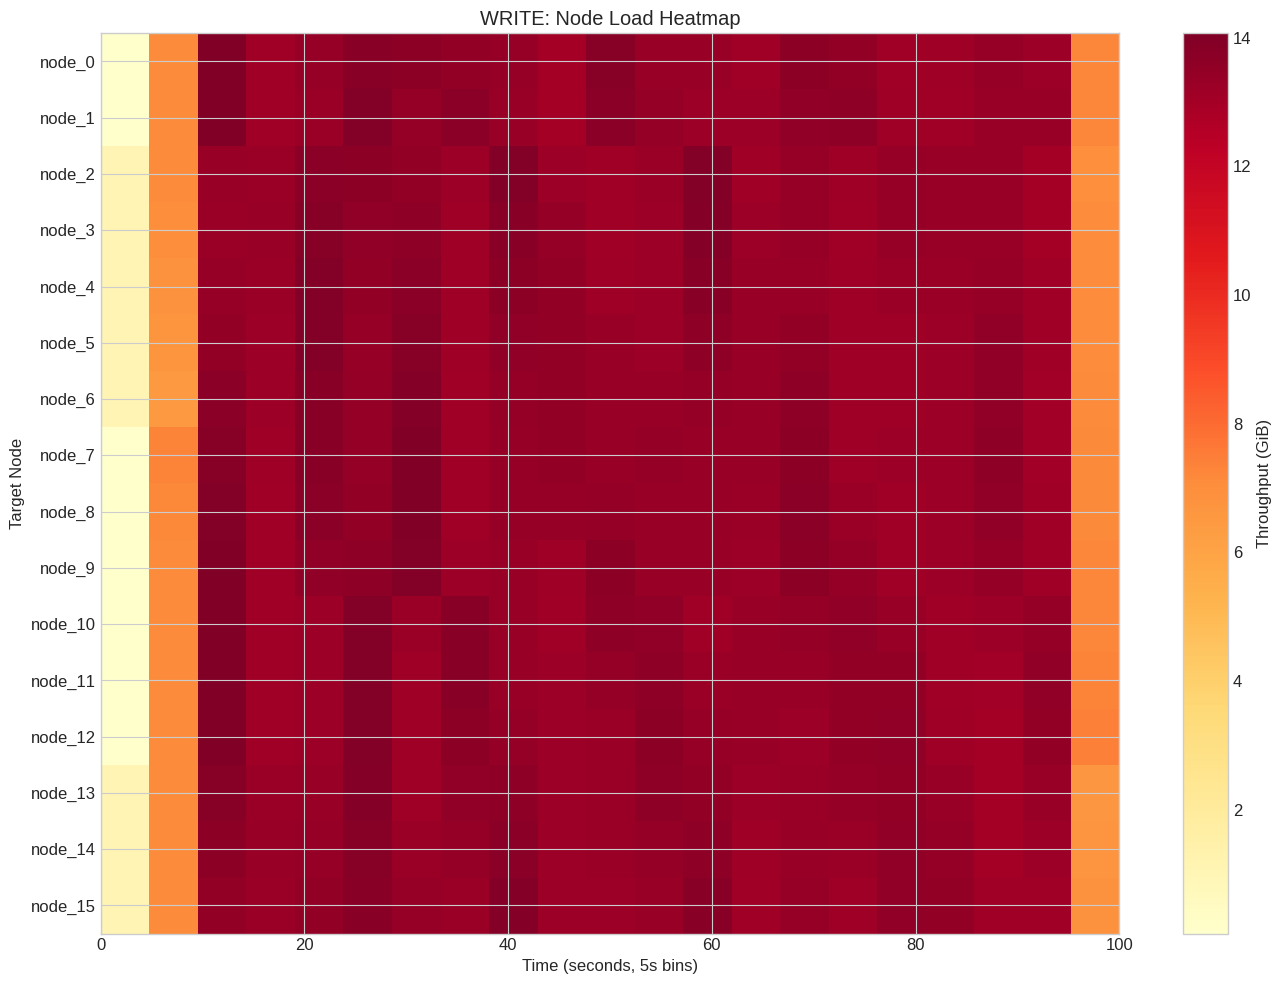

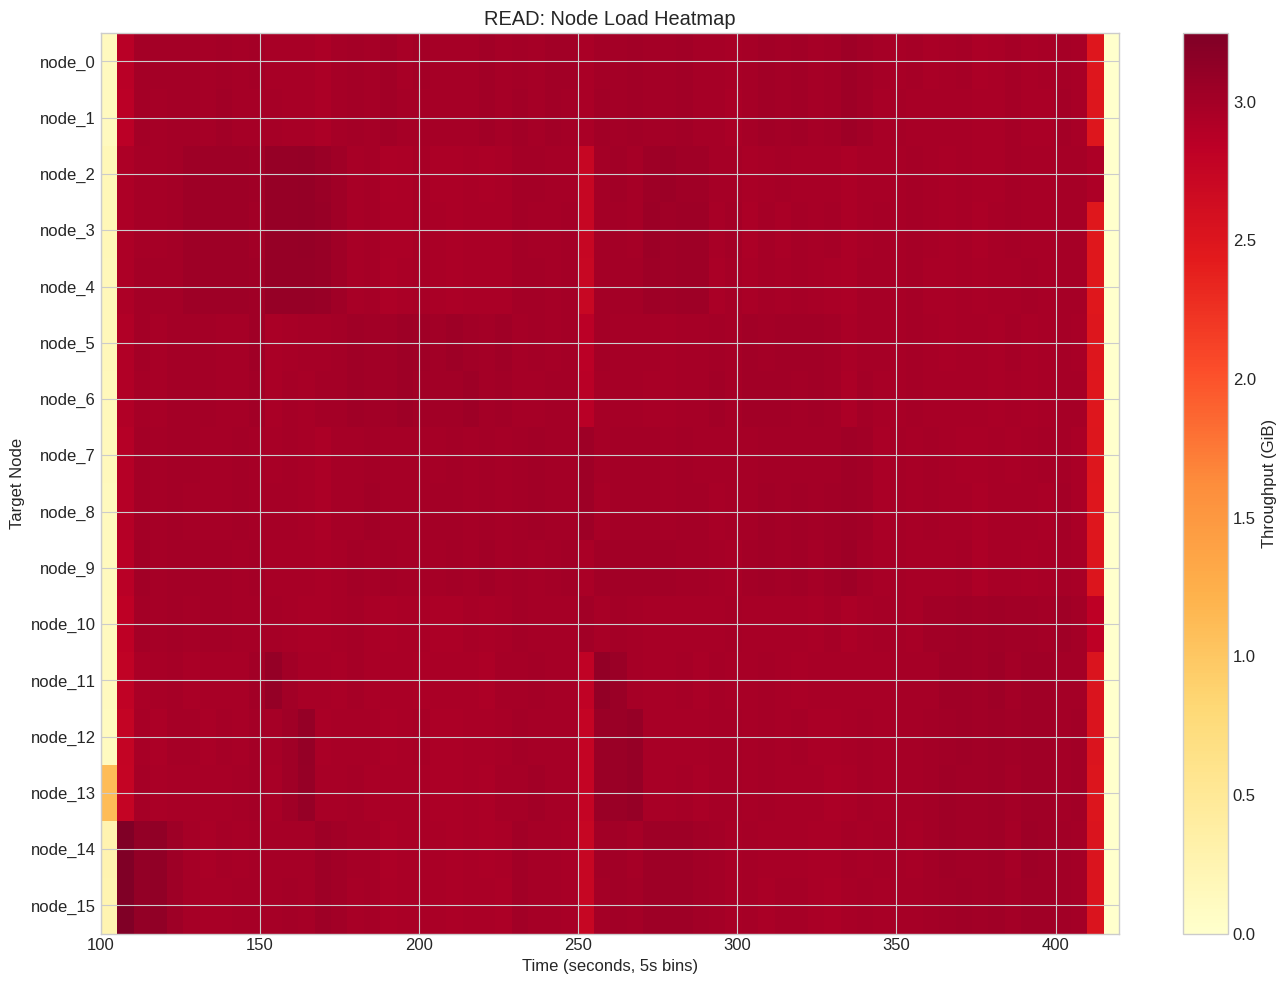

In [8]:
def plot_heatmap(data, title, filename, time_bin=5):
    """Plot heatmap of node load over time (binned)"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Bin time into larger intervals for clearer heatmap
    data = data.copy()
    data['time_bin'] = (data['time_relative'] // time_bin) * time_bin
    
    # Aggregate by time bin and target node
    heatmap_data = data.groupby(['time_bin', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(heatmap_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    heatmap_data = heatmap_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    im = ax.imshow(heatmap_data.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_data.index.min(), heatmap_data.index.max(), 
                           len(heatmap_data.columns)-0.5, -0.5])
    
    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('Target Node')
    ax.set_title(title)
    ax.set_yticks(range(len(heatmap_data.columns)))
    ax.set_yticklabels(heatmap_data.columns)
    
    cbar = plt.colorbar(im, ax=ax, label='Throughput (GiB)')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150)
    plt.show()

plot_heatmap(df_write, 'WRITE: Node Load Heatmap', 'write_heatmap.png', time_bin=5)
plot_heatmap(df_read, 'READ: Node Load Heatmap', 'read_heatmap.png', time_bin=5)

## 6. Load Imbalance Analysis

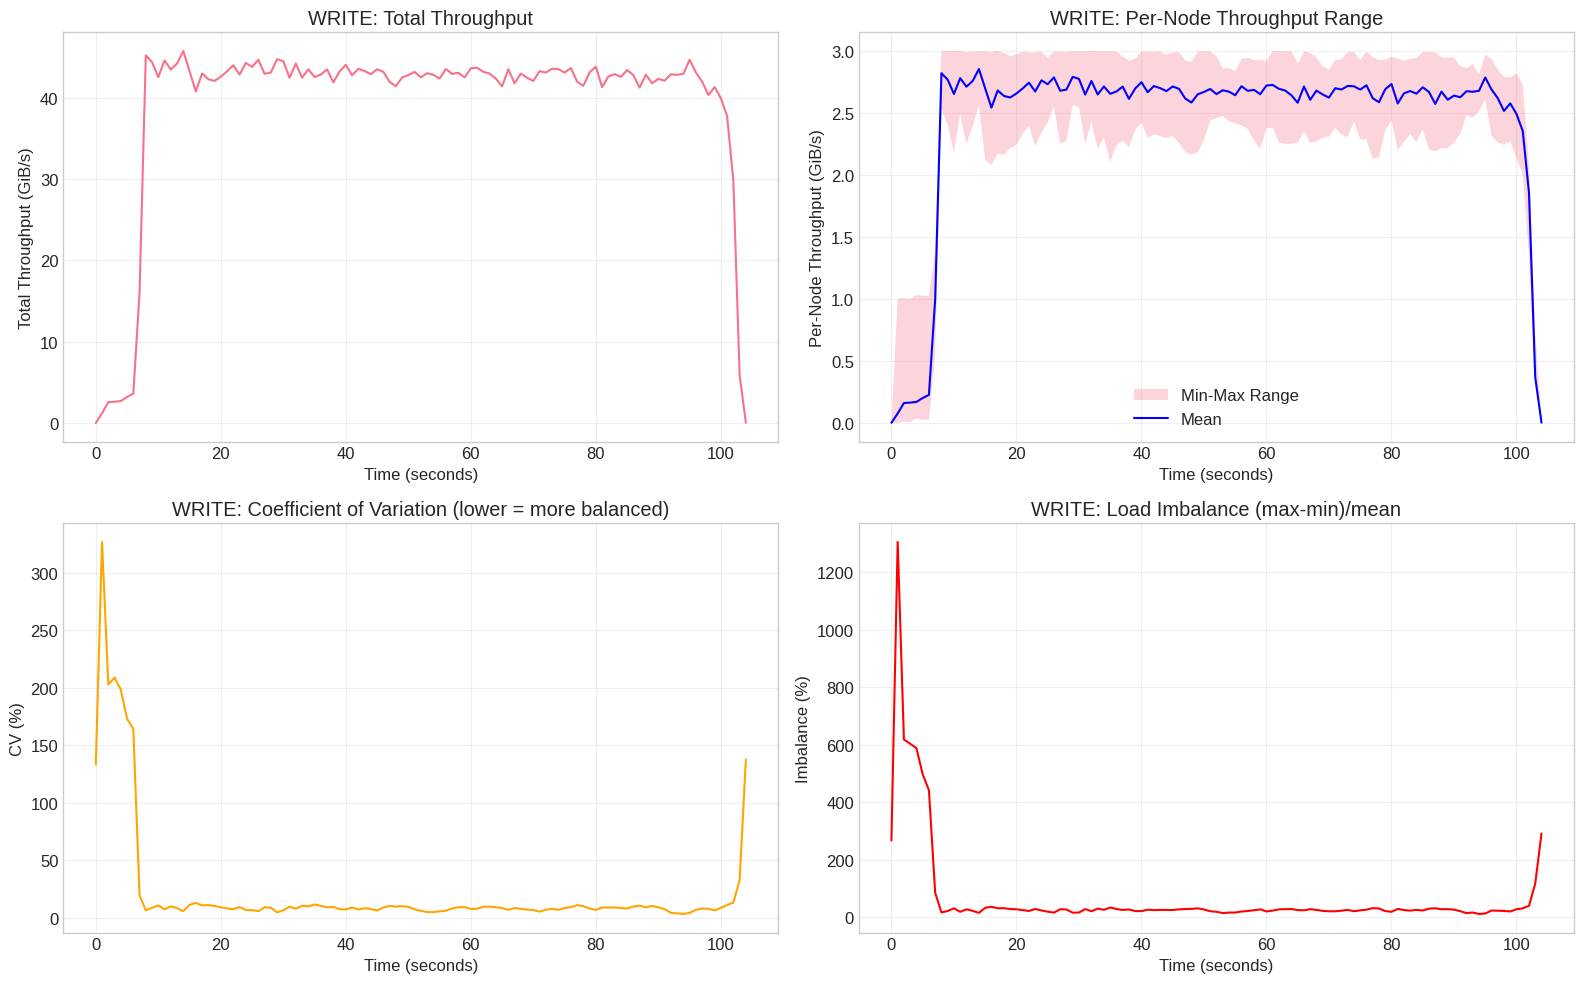


WRITE - Summary Statistics:
  Average total throughput: 39.01 GiB/s
  Average per-node throughput: 2.44 GiB/s
  Average CV: 22.78%
  Average imbalance: 67.69%
  Max imbalance: 1304.46%


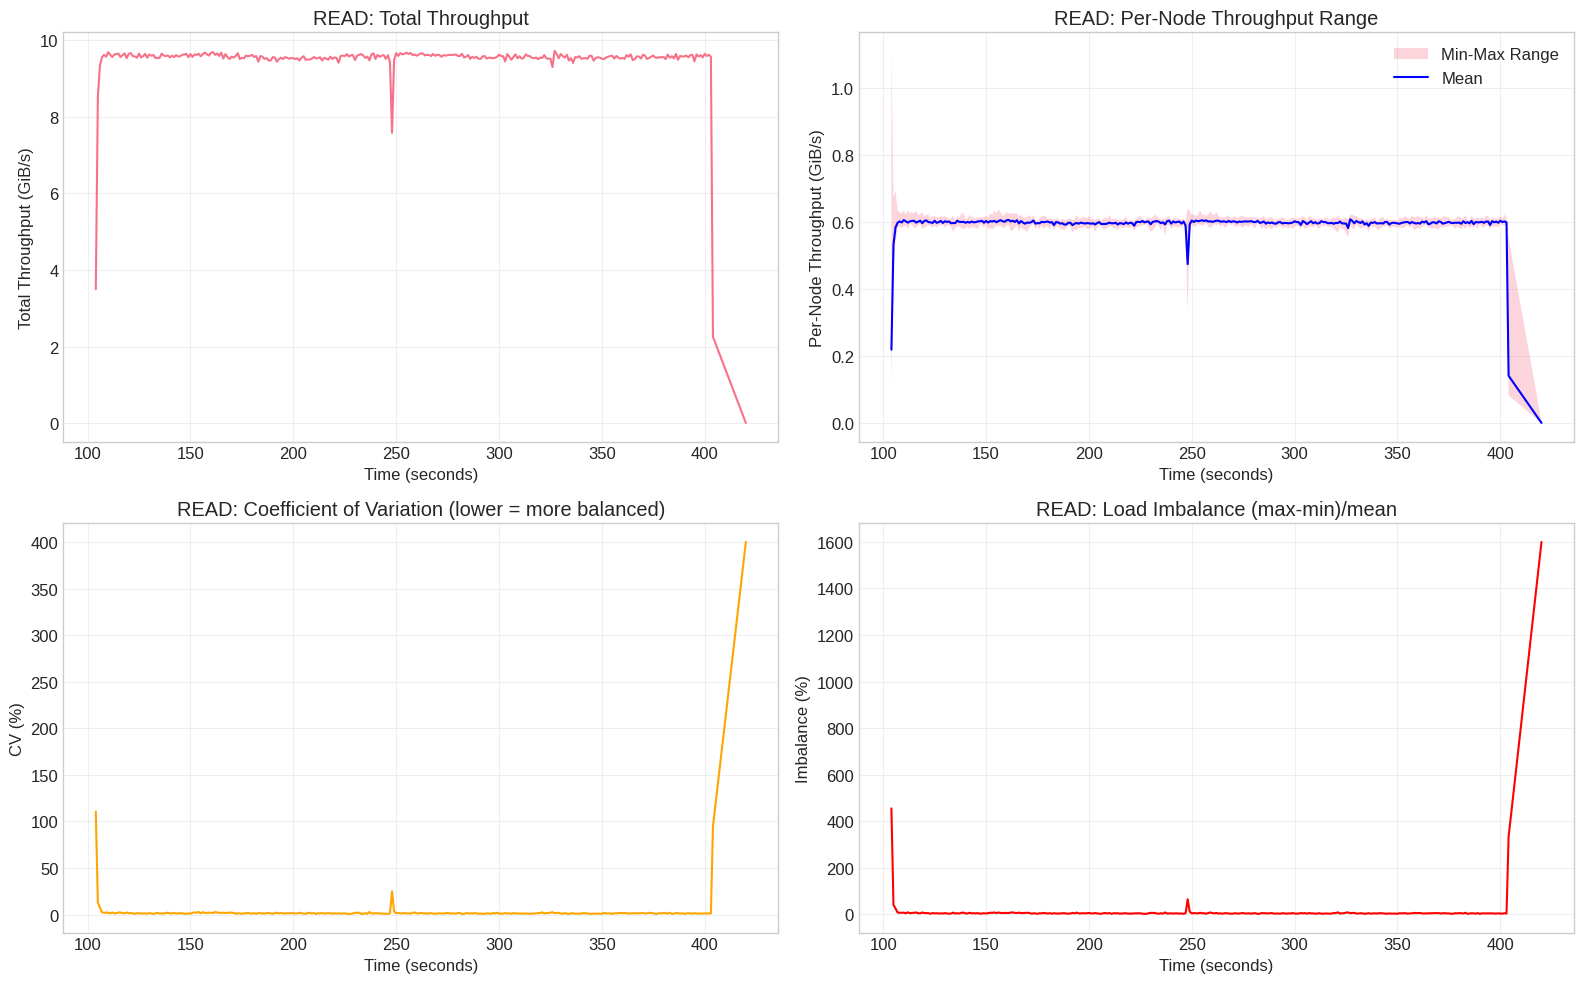


READ - Summary Statistics:
  Average total throughput: 9.48 GiB/s
  Average per-node throughput: 0.59 GiB/s
  Average CV: 3.57%
  Average imbalance: 13.19%
  Max imbalance: 1600.00%


In [9]:
def analyze_load_imbalance(data, title):
    """Analyze load imbalance across nodes over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate by time and target node
    node_throughput = data.groupby(['time_relative', 'target_node'])['total_gib'].sum().unstack(fill_value=0)
    
    # Calculate per-second statistics
    stats = pd.DataFrame({
        'mean': node_throughput.mean(axis=1),
        'std': node_throughput.std(axis=1),
        'min': node_throughput.min(axis=1),
        'max': node_throughput.max(axis=1),
        'total': node_throughput.sum(axis=1)
    })
    stats['cv'] = stats['std'] / stats['mean'] * 100  # Coefficient of variation (%)
    stats['imbalance'] = (stats['max'] - stats['min']) / stats['mean'] * 100
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Total throughput
    ax = axes[0, 0]
    ax.plot(stats.index, stats['total'], linewidth=1.5)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Total Throughput (GiB/s)')
    ax.set_title(f'{title}: Total Throughput')
    ax.grid(True, alpha=0.3)
    
    # Min/Max/Mean per node
    ax = axes[0, 1]
    ax.fill_between(stats.index, stats['min'], stats['max'], alpha=0.3, label='Min-Max Range')
    ax.plot(stats.index, stats['mean'], linewidth=1.5, label='Mean', color='blue')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Per-Node Throughput (GiB/s)')
    ax.set_title(f'{title}: Per-Node Throughput Range')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Coefficient of Variation
    ax = axes[1, 0]
    ax.plot(stats.index, stats['cv'], linewidth=1.5, color='orange')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('CV (%)')
    ax.set_title(f'{title}: Coefficient of Variation (lower = more balanced)')
    ax.grid(True, alpha=0.3)
    
    # Imbalance percentage
    ax = axes[1, 1]
    ax.plot(stats.index, stats['imbalance'], linewidth=1.5, color='red')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Imbalance (%)')
    ax.set_title(f'{title}: Load Imbalance (max-min)/mean')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f'{title.lower().replace(":", "").replace(" ", "_")}_imbalance.png', dpi=150)
    plt.show()
    
    # Print summary statistics
    print(f"\n{title} - Summary Statistics:")
    print(f"  Average total throughput: {stats['total'].mean():.2f} GiB/s")
    print(f"  Average per-node throughput: {stats['mean'].mean():.2f} GiB/s")
    print(f"  Average CV: {stats['cv'].mean():.2f}%")
    print(f"  Average imbalance: {stats['imbalance'].mean():.2f}%")
    print(f"  Max imbalance: {stats['imbalance'].max():.2f}%")

analyze_load_imbalance(df_write, 'WRITE')
analyze_load_imbalance(df_read, 'READ')

## 7. Transfer Count Analysis

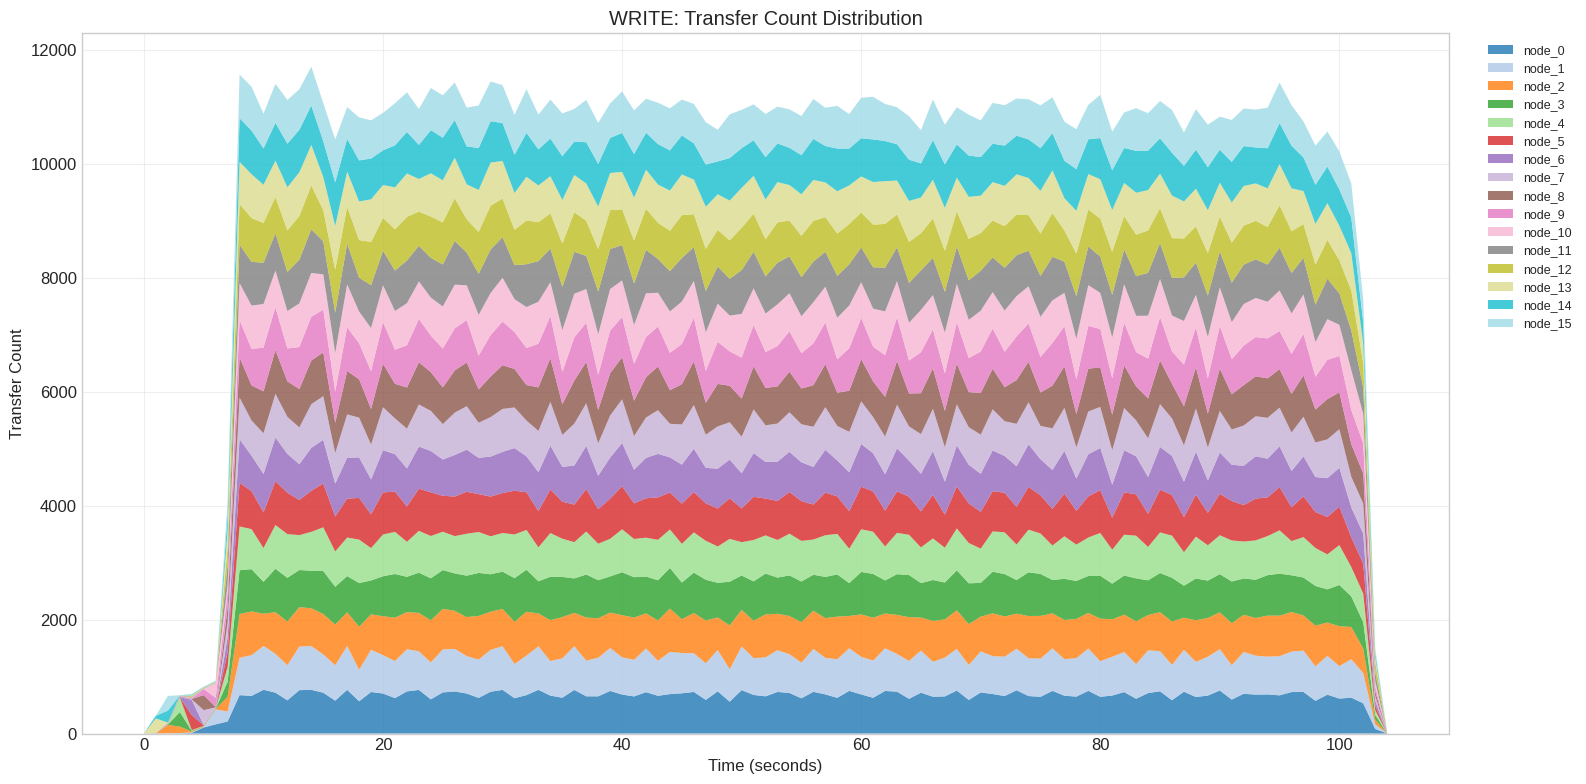

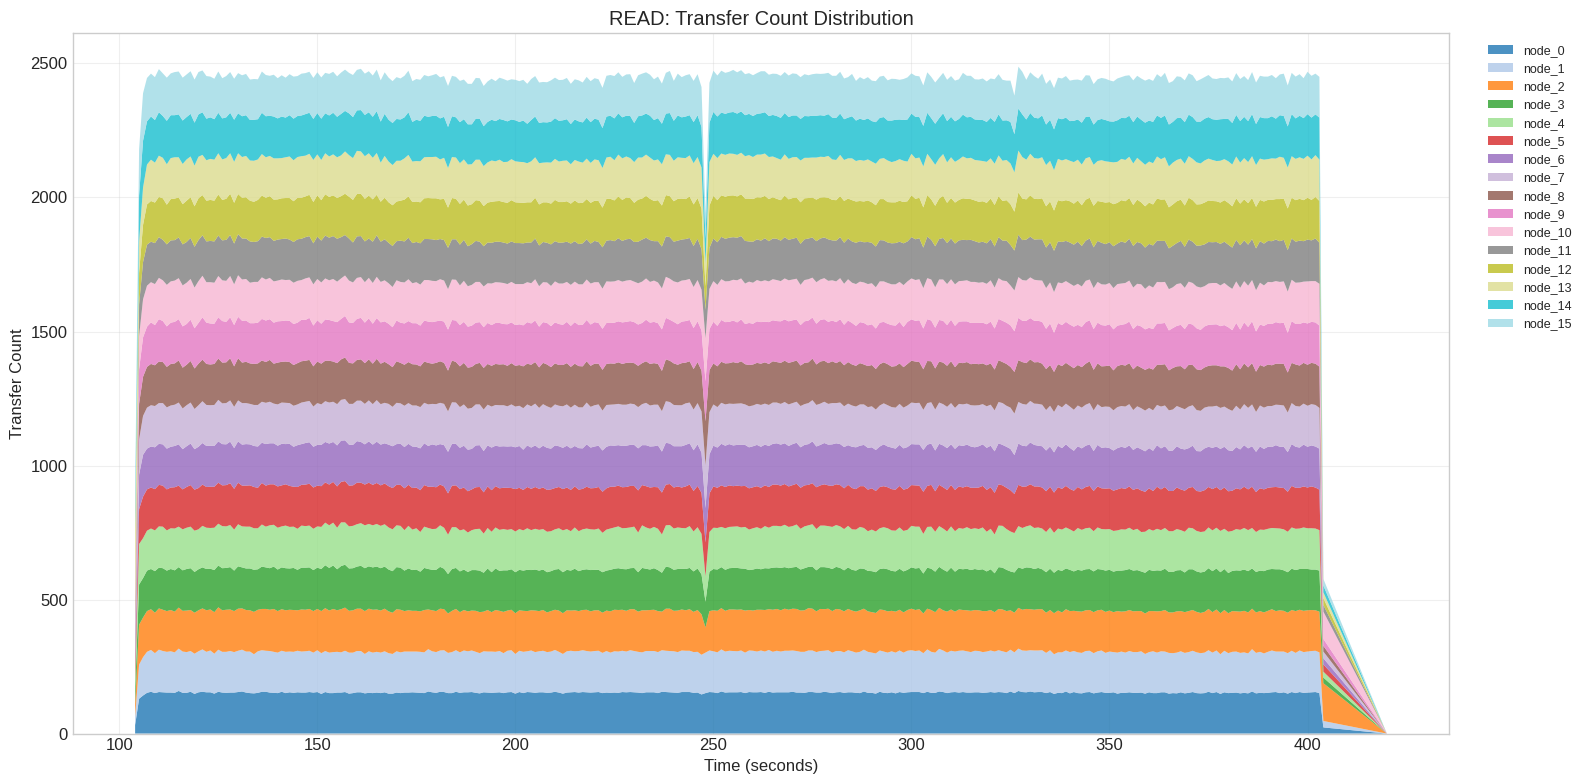

In [10]:
def plot_transfer_counts(data, title, filename):
    """Plot transfer counts per node over time"""
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    # Aggregate transfer counts by time and target node
    count_data = data.groupby(['time_relative', 'target_node'])['transfer_count'].sum().unstack(fill_value=0)
    
    # Sort columns naturally
    sorted_cols = sorted(count_data.columns, key=lambda x: int(x.split('_')[1]) if '_' in x else x)
    count_data = count_data[sorted_cols]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(count_data.columns)))
    
    ax.stackplot(count_data.index, 
                 [count_data[col] for col in count_data.columns],
                 labels=count_data.columns,
                 colors=colors,
                 alpha=0.8)
    
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Transfer Count')
    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150, bbox_inches='tight')
    plt.show()

plot_transfer_counts(df_write, 'WRITE: Transfer Count Distribution', 'write_transfer_counts.png')
plot_transfer_counts(df_read, 'READ: Transfer Count Distribution', 'read_transfer_counts.png')

## 8. Summary Table

In [11]:
# Total bytes per target node
summary = df.groupby(['op', 'target_node']).agg({
    'total_bytes': 'sum',
    'transfer_count': 'sum'
}).reset_index()

summary['total_gib'] = summary['total_bytes'] / (1024**3)
summary['avg_transfer_size_mb'] = summary['total_bytes'] / summary['transfer_count'] / (1024**2)

print("=== Per-Node Summary ===")
for op in ['WRITE', 'READ']:
    print(f"\n{op}:")
    op_data = summary[summary['op'] == op].sort_values('target_node')
    display(op_data[['target_node', 'total_gib', 'transfer_count', 'avg_transfer_size_mb']])

=== Per-Node Summary ===

WRITE:


,target_node,total_gib,transfer_count,avg_transfer_size_mb
16,node_0,256.0,65536,4.0
17,node_1,256.0,65536,4.0
18,node_10,256.0,65536,4.0
19,node_11,256.0,65536,4.0
20,node_12,256.0,65536,4.0
21,node_13,256.0,65536,4.0
22,node_14,256.0,65536,4.0
23,node_15,256.0,65536,4.0
24,node_2,256.0,65536,4.0
25,node_3,256.0,65536,4.0



READ:


,target_node,total_gib,transfer_count,avg_transfer_size_mb
0,node_0,178.859375,45788,4.0
1,node_1,178.855469,45787,4.0
2,node_10,178.843750,45784,4.0
3,node_11,178.523438,45702,4.0
4,node_12,178.500000,45696,4.0
5,node_13,179.480469,45947,4.0
6,node_14,179.464844,45943,4.0
7,node_15,179.445312,45938,4.0
8,node_2,179.433594,45935,4.0
9,node_3,178.960938,45814,4.0
